## Importing libraries

In [329]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from dotenv import load_dotenv
import os
import zipfile
import shutil
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Retrieving api key
load_dotenv("../key.env")
api_key = os.getenv("API_KEY")

## Reading datasets

In [330]:
top_20_overlap_service = pd.read_csv("../datasets/filtered_final_results4.csv").head(20)
top_20_overlap_service['ServiceNo'] = top_20_overlap_service['ServiceNo'].astype(str)
print(top_20_overlap_service.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                20 non-null     int64  
 1   ServiceNo                 20 non-null     object 
 2   TotalStops                20 non-null     int64  
 3   WeightedParallelScore     20 non-null     float64
 4   TrainLineParallelData     20 non-null     object 
 5   UniqueParallelStopsCount  20 non-null     int64  
 6   LongestConsecutiveLength  20 non-null     int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 1.2+ KB
None


In [331]:
top_50_overlap_service = pd.read_csv('../datasets/filtered_final_results4.csv').head(50)
top_50_overlap_service['ServiceNo'] = top_50_overlap_service['ServiceNo'].astype(str)

## Feature 1: Passenger Volume

In [332]:
pv_trend = pd.read_csv("../datasets/pv_eda/routes_pv_trend.csv")
print(pv_trend.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ServiceNo     400 non-null    object 
 1   2024-07       400 non-null    float64
 2   2024-08       400 non-null    float64
 3   2024-09       400 non-null    float64
 4   Trend         400 non-null    object 
 5   Trend_Binary  400 non-null    int64  
 6   Change        400 non-null    float64
 7   Average       400 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 25.1+ KB
None


In [333]:
top_20_pv_trend = pd.merge(top_20_overlap_service, pv_trend, on="ServiceNo", how="inner")
print(top_20_pv_trend.head())

   Unnamed: 0 ServiceNo  TotalStops  WeightedParallelScore  \
0         254        67         163               1.181314   
1         159         2         131               1.070266   
2         219        48         105               1.032547   
3         113       170         130               1.012027   
4          12       107          79               0.939744   

                               TrainLineParallelData  \
0  {'BP': [{'ParallelStopCount': 5, 'ParallelStop...   
1  {'BP': [{'ParallelStopCount': 0, 'ParallelStop...   
2  {'BP': [{'ParallelStopCount': 0, 'ParallelStop...   
3  {'BP': [{'ParallelStopCount': 0, 'ParallelStop...   
4  {'BP': [{'ParallelStopCount': 0, 'ParallelStop...   

   UniqueParallelStopsCount  LongestConsecutiveLength     2024-07     2024-08  \
0                       135                        25  40651926.0  40107168.0   
1                        73                        29  16194066.0  15879842.0   
2                        76                    

In [334]:
top_50_pv_trend = pd.merge(top_50_overlap_service, pv_trend, on="ServiceNo", how="inner")
print(top_50_pv_trend.head())

   Unnamed: 0 ServiceNo  TotalStops  WeightedParallelScore  \
0         254        67         163               1.181314   
1         159         2         131               1.070266   
2         219        48         105               1.032547   
3         113       170         130               1.012027   
4          12       107          79               0.939744   

                               TrainLineParallelData  \
0  {'BP': [{'ParallelStopCount': 5, 'ParallelStop...   
1  {'BP': [{'ParallelStopCount': 0, 'ParallelStop...   
2  {'BP': [{'ParallelStopCount': 0, 'ParallelStop...   
3  {'BP': [{'ParallelStopCount': 0, 'ParallelStop...   
4  {'BP': [{'ParallelStopCount': 0, 'ParallelStop...   

   UniqueParallelStopsCount  LongestConsecutiveLength     2024-07     2024-08  \
0                       135                        25  40651926.0  40107168.0   
1                        73                        29  16194066.0  15879842.0   
2                        76                    

In [335]:
# Normalize 'Change' and 'Average' by 'TotalStops'
top_20_pv_trend['Change_Normalized'] = top_20_pv_trend['Change'] / top_20_pv_trend['TotalStops']
top_20_pv_trend['Average_Normalized'] = top_20_pv_trend['Average'] / top_20_pv_trend['TotalStops']

# Calculate z-score for 'Change_Normalized' across the entire dataset
change_mean = top_20_pv_trend['Change_Normalized'].mean()
change_std = top_20_pv_trend['Change_Normalized'].std()
top_20_pv_trend['Change_Standardized'] = (top_20_pv_trend['Change_Normalized'] - change_mean) / change_std

# Adjust signs based on 'Trend'
top_20_pv_trend.loc[top_20_pv_trend['Trend'] == 'Decreasing', 'Change_Standardized'] = \
   - np.abs(top_20_pv_trend.loc[top_20_pv_trend['Trend'] == 'Decreasing', 'Change_Standardized'])

top_20_pv_trend.loc[top_20_pv_trend['Trend'] == 'Increasing', 'Change_Standardized'] = \
    np.abs(top_20_pv_trend.loc[top_20_pv_trend['Trend'] == 'Increasing', 'Change_Standardized'])

# Scale 'Average_Normalized' to the range 0-1 for the entire dataset
scaler = MinMaxScaler(feature_range=(0, 1))
top_20_pv_trend['Average_Standardized'] = scaler.fit_transform(top_20_pv_trend[['Average_Normalized']])

top_20_pv_trend = top_20_pv_trend[['ServiceNo', 'TotalStops', 'WeightedParallelScore', 'TrainLineParallelData', 
                                   'Trend_Binary', 'Change_Standardized', 'Average_Standardized']]

# Preview the resulting DataFrame
print(top_20_pv_trend)

   ServiceNo  TotalStops  WeightedParallelScore  \
0         67         163               1.181314   
1          2         131               1.070266   
2         48         105               1.032547   
3        170         130               1.012027   
4        107          79               0.939744   
5         26          64               0.939020   
6        133          86               0.854870   
7         36          61               0.839344   
8         24         100               0.742000   
9        147         146               0.740808   
10        10         148               0.736486   
11       188         111               0.735088   
12       852          96               0.727573   
13       143         149               0.727441   
14        80         118               0.719598   
15       960          92               0.719565   
16        91          19               0.715789   
17        23          43               0.706977   
18        47          51       

In [336]:
# Normalize 'Change' and 'Average' by 'TotalStops'
top_50_pv_trend['Change_Normalized'] = top_50_pv_trend['Change'] / top_50_pv_trend['TotalStops']
top_50_pv_trend['Average_Normalized'] = top_50_pv_trend['Average'] / top_50_pv_trend['TotalStops']

# Calculate z-score for 'Change_Normalized' across the entire dataset
change_mean = top_50_pv_trend['Change_Normalized'].mean()
change_std = top_50_pv_trend['Change_Normalized'].std()
top_50_pv_trend['Change_Standardized'] = (top_50_pv_trend['Change_Normalized'] - change_mean) / change_std

# Adjust signs based on 'Trend'
top_50_pv_trend.loc[top_50_pv_trend['Trend'] == 'Decreasing', 'Change_Standardized'] = \
   - np.abs(top_50_pv_trend.loc[top_50_pv_trend['Trend'] == 'Decreasing', 'Change_Standardized'])

top_50_pv_trend.loc[top_50_pv_trend['Trend'] == 'Increasing', 'Change_Standardized'] = \
    np.abs(top_50_pv_trend.loc[top_50_pv_trend['Trend'] == 'Increasing', 'Change_Standardized'])

# Scale 'Average_Normalized' to the range 0-1 for the entire dataset
scaler = MinMaxScaler(feature_range=(0, 1))
top_50_pv_trend['Average_Standardized'] = scaler.fit_transform(top_50_pv_trend[['Average_Normalized']])

top_50_pv_trend = top_50_pv_trend[['ServiceNo', 'TotalStops', 'WeightedParallelScore', 'TrainLineParallelData', 
                                   'Trend_Binary', 'Change_Standardized', 'Average_Standardized']]

# Preview the resulting DataFrame
print(top_50_pv_trend)

   ServiceNo  TotalStops  WeightedParallelScore  \
0         67         163               1.181314   
1          2         131               1.070266   
2         48         105               1.032547   
3        170         130               1.012027   
4        107          79               0.939744   
5         26          64               0.939020   
6        133          86               0.854870   
7         36          61               0.839344   
8         24         100               0.742000   
9        147         146               0.740808   
10        10         148               0.736486   
11       188         111               0.735088   
12       852          96               0.727573   
13       143         149               0.727441   
14        80         118               0.719598   
15       960          92               0.719565   
16        91          19               0.715789   
17        23          43               0.706977   
18        47          51       

## Count of alternative bus routes

In [337]:
%run get_bus_info_function.ipynb
bus_services_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusServices", api_key)
bus_routes_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusRoutes", api_key)
bus_stops_df = get_bus_info("https://datamall2.mytransport.sg/ltaodataservice/BusStops", api_key)

In [338]:
# Filter for Trunk Services
trunk_buses_df = bus_services_df[bus_services_df['Category'] == "TRUNK"]
trunk_buses_df = trunk_buses_df['ServiceNo']
trunk_bus_routes_df = pd.merge(trunk_buses_df, bus_routes_df, on='ServiceNo', how='inner')

# Select relevant columns
trunk_bus_routes_df = trunk_bus_routes_df[['ServiceNo', 'Direction', 'StopSequence', 'BusStopCode']]

# Sort the trunk bus routes by Direction and StopSequence
trunk_bus_routes_df.sort_values(by=['ServiceNo', 'Direction', 'StopSequence'], inplace=True)

# Group by ServiceNo and create an ordered list of BusStopCodes for each service
ordered_stops = trunk_bus_routes_df.groupby('ServiceNo').agg(
    OrderedBusStops=('BusStopCode', lambda x: list(x))
).reset_index()

# Display the result
print(ordered_stops.head())

  ServiceNo                                    OrderedBusStops
0        10  [75009, 75009, 76059, 76059, 76069, 76069, 962...
1       100  [66009, 66009, 62129, 62129, 62119, 62119, 610...
2      100A  [66009, 62129, 62119, 61049, 61039, 70069, 700...
3       101  [66009, 62131, 62141, 63011, 63021, 63031, 630...
4       102  [64009, 64041, 64051, 64061, 64401, 67739, 677...


## Feature 3 : Average Distance of bus stops to train stations 

In [339]:
avg_dist_df = pd.read_pickle("../datasets/overlap_results_with_road_distance3.pkl")

In [340]:
top_20_features = pd.merge(top_20_pv_trend,avg_dist_df, on = 'ServiceNo')

In [341]:
top_50_features = pd.merge(top_50_pv_trend,avg_dist_df, on = 'ServiceNo')

In [342]:
top_20_features = top_20_features[['ServiceNo','WeightedParallelScore','Change_Standardized','AvgNormalizedDistance']]
top_20_features.columns = ['ServiceNo', 'WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']

In [343]:
top_50_features = top_50_features[['ServiceNo','WeightedParallelScore','Change_Standardized','AvgNormalizedDistance']]
top_50_features.columns = ['ServiceNo', 'WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']

In [344]:
# # Apply StandardScaler to standardize the features
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled_20 = scaler.fit_transform(top_20_features[['WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']])

In [345]:
# # Apply StandardScaler to standardize the features
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(top_50_features[['WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']])

### KNN :50 bus services

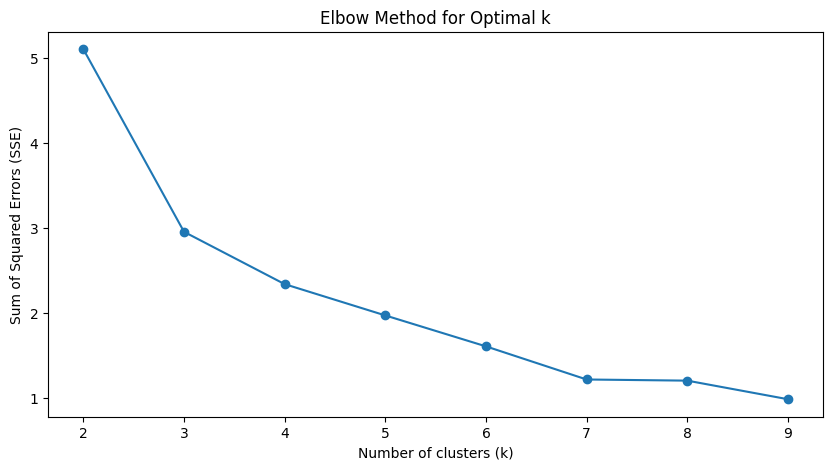

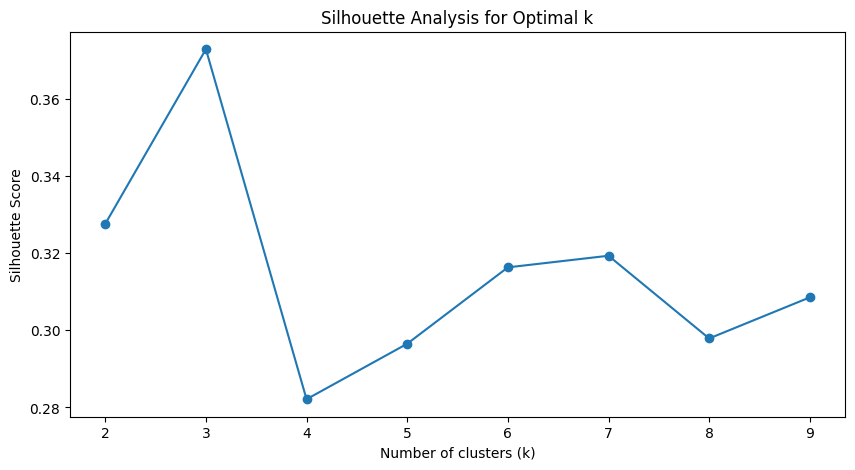

Silhouette score for k=2: 0.328
Silhouette score for k=3: 0.373
Silhouette score for k=4: 0.282
Silhouette score for k=5: 0.297
Silhouette score for k=6: 0.316
Silhouette score for k=7: 0.319
Silhouette score for k=8: 0.298
Silhouette score for k=9: 0.309


In [346]:
# Elbow Method
sse = []  # Sum of squared errors
range_k = range(2, 10)  # Range of k to test

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)  # Inertia is the sum of squared distances to the nearest cluster center

# Plot the SSE for each k
plt.figure(figsize=(10, 5))
plt.plot(range_k, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Silhouette Analysis
silhouette_scores = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores for each k
plt.figure(figsize=(10, 5))
plt.plot(range_k, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

# Print out the silhouette scores for inspection
for i, score in zip(range_k, silhouette_scores):
    print(f"Silhouette score for k={i}: {score:.3f}")

Cluster Centers:
[[0.14418008 0.6856943  0.69056906]
 [0.16209578 0.74785677 0.26929235]
 [0.74626092 0.66129069 0.55009473]]
Top 50 bus service with cluster assignments:
   WeightedParallelScore  AvgPVChange  AvgDistanceToMRT  Cluster
0               1.000000     0.620477          0.299569        2
1               0.814821     0.741500          0.777173        2
2               0.751921     0.678407          0.452929        2
3               0.717702     0.692475          0.448081        2
4               0.597165     0.760648          0.334274        2


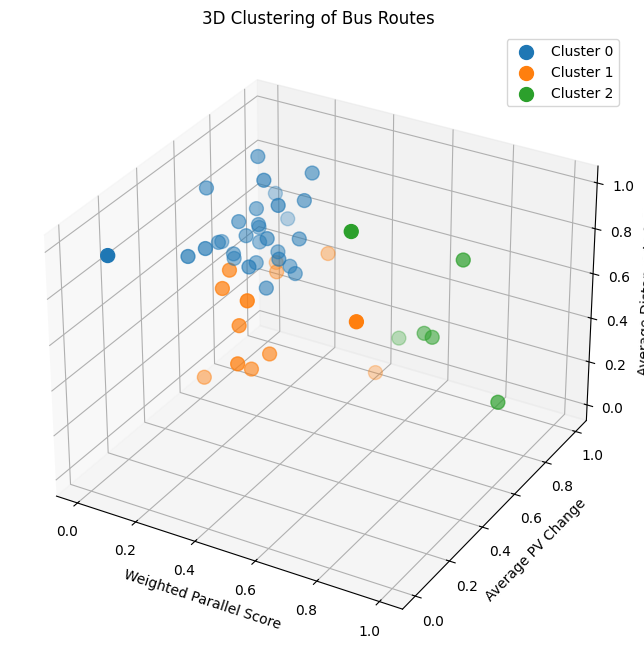

In [347]:
k = 3 # Optimal number of clusters

# Perform KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# Create a DataFrame to store the results
columns = ['WeightedParallelScore', 'AvgPVChange', 'AvgDistanceToMRT']  # Replace with your actual column names if needed
top_50_features_df = pd.DataFrame(features_scaled, columns=columns)
top_50_features_df['Cluster'] = cluster_labels

# Analyze the clusters
print("Cluster Centers:")
print(kmeans.cluster_centers_)

# Display the first few rows of the DataFrame with cluster assignments
print("Top 50 bus service with cluster assignments:")
print(top_50_features_df.head())


from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(k):
    cluster_data = top_50_features_df[top_50_features_df['Cluster'] == i]
    ax.scatter(
        cluster_data['WeightedParallelScore'], 
        cluster_data['AvgPVChange'], 
        cluster_data['AvgDistanceToMRT'], 
        label=f'Cluster {i}', 
        s=100  # Adjust the size of the dots
    )

ax.set_xlabel('Weighted Parallel Score')
ax.set_ylabel('Average PV Change')
ax.set_zlabel('Average Distance to MRT')
ax.set_title('3D Clustering of Bus Routes')
plt.legend()
plt.show()




In [348]:
# Ensure that you are assigning the cluster column using .loc
top_50_features.loc[:, 'Clusters_KNN'] = top_50_features_df['Cluster'].values

In [349]:
top_50_features

,ServiceNo,WeightedParallelScore,PVChange,AvgDistanceToMRT,Clusters_KNN
0,67,1.181314,-0.842202,0.737742,2
1,2,1.070266,-0.140829,0.848269,2
2,48,1.032547,-0.506475,0.773233,2
3,170,1.012027,-0.424945,0.772111,2
4,107,0.939744,-0.029855,0.745774,2
5,26,0.939020,-1.689713,0.897184,2
6,133,0.854870,-0.059349,0.751249,1
7,36,0.839344,0.900896,0.668416,1
8,24,0.742000,-0.133153,0.823632,0
9,147,0.740808,-0.255087,0.790455,0


### knn : 20 BUS Services

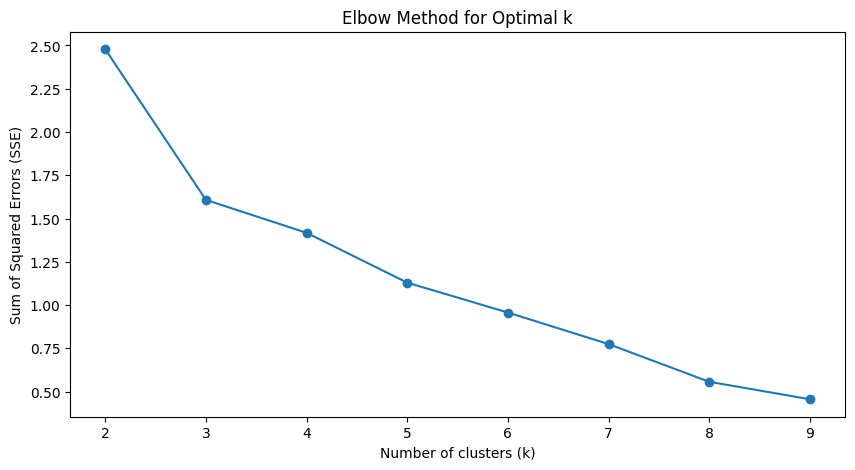

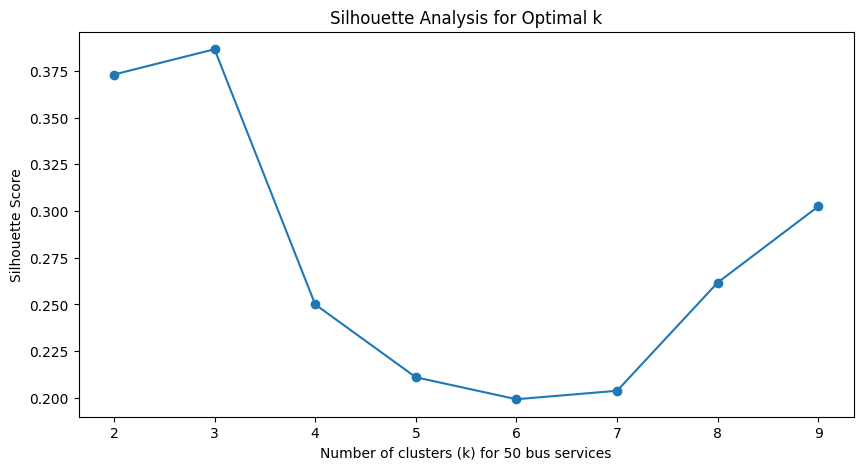

Silhouette score for k=2: 0.373
Silhouette score for k=3: 0.387
Silhouette score for k=4: 0.250
Silhouette score for k=5: 0.211
Silhouette score for k=6: 0.199
Silhouette score for k=7: 0.204
Silhouette score for k=8: 0.262
Silhouette score for k=9: 0.303


In [350]:
# Elbow Method
sse = []  # Sum of squared errors
range_k = range(2, 10)  # Range of k to test

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled_20)
    sse.append(kmeans.inertia_)  # Inertia is the sum of squared distances to the nearest cluster center

# Plot the SSE for each k
plt.figure(figsize=(10, 5))
plt.plot(range_k, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Silhouette Analysis
silhouette_scores = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled_20)
    silhouette_avg = silhouette_score(features_scaled_20, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores for each k
plt.figure(figsize=(10, 5))
plt.plot(range_k, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k) for 50 bus services')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

# Print out the silhouette scores for inspection
for i, score in zip(range_k, silhouette_scores):
    print(f"Silhouette score for k={i}: {score:.3f}")

Cluster Centers:
[[0.16576571 0.71016317 0.23780148]
 [0.10181767 0.38943153 0.71479694]
 [0.72356179 0.41712712 0.46776547]]
Top 50 bus service with cluster assignments:
   WeightedParallelScore  AvgPVChange  AvgDistanceToMRT  Cluster
0               1.000000     0.284063          0.303042        2
1               0.771142     0.495540          0.786181        2
2               0.693406     0.372986          0.458180        2
3               0.651115     0.400312          0.453275        2
4               0.502147     0.532735          0.338149        2


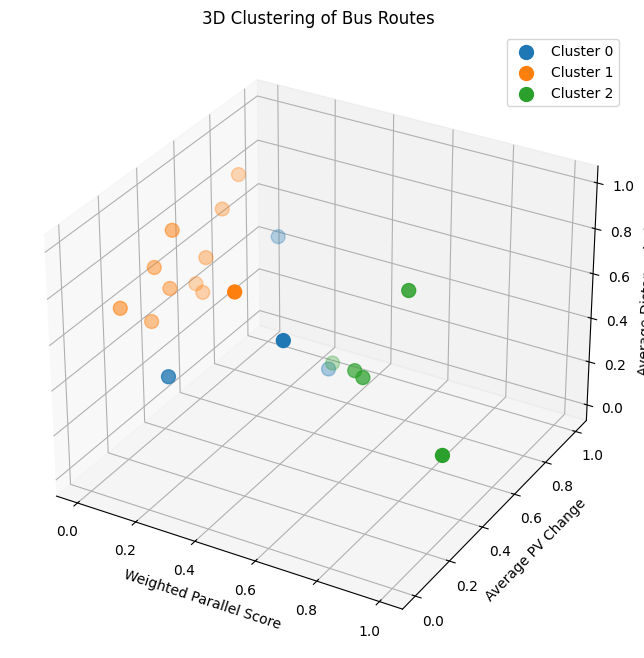

In [351]:
k = 3  # Optimal number of clusters

# Perform KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled_20)

# Create a DataFrame to store the results
columns = ['WeightedParallelScore', 'AvgPVChange', 'AvgDistanceToMRT']  # Replace with your actual column names if needed
top_20_features_df = pd.DataFrame(features_scaled_20, columns=columns)
top_20_features_df['Cluster'] = cluster_labels

# Analyze the clusters
print("Cluster Centers:")
print(kmeans.cluster_centers_)

# Display the first few rows of the DataFrame with cluster assignments
print("Top 50 bus service with cluster assignments:")
print(top_20_features_df.head())


from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(k):
    cluster_data = top_20_features_df[top_20_features_df['Cluster'] == i]
    ax.scatter(
        cluster_data['WeightedParallelScore'], 
        cluster_data['AvgPVChange'], 
        cluster_data['AvgDistanceToMRT'], 
        label=f'Cluster {i}', 
        s=100  # Adjust the size of the dots
    )

ax.set_xlabel('Weighted Parallel Score')
ax.set_ylabel('Average PV Change')
ax.set_zlabel('Average Distance to MRT')
ax.set_title('3D Clustering of Bus Routes')
plt.legend()
plt.show()




In [352]:
# Ensure that you are assigning the cluster column using .loc
top_20_features.loc[:, 'Clusters_KNN'] = top_20_features_df['Cluster'].values

In [361]:
top_20_features

,ServiceNo,WeightedParallelScore,PVChange,AvgDistanceToMRT,Clusters_KNN,Cluster_HC
0,67,1.181314,-1.093576,0.737742,2,1
1,2,1.070266,-0.238558,0.848269,2,1
2,48,1.032547,-0.734054,0.773233,2,1
3,170,1.012027,-0.623571,0.772111,2,1
4,107,0.939744,-0.088174,0.745774,2,1
5,26,0.939020,-2.242063,0.897184,1,3
6,133,0.854870,-0.032710,0.751249,0,1
7,36,0.839344,1.268546,0.668416,0,0
8,24,0.742000,-0.228155,0.823632,1,2
9,147,0.740808,-0.297960,0.790455,1,2


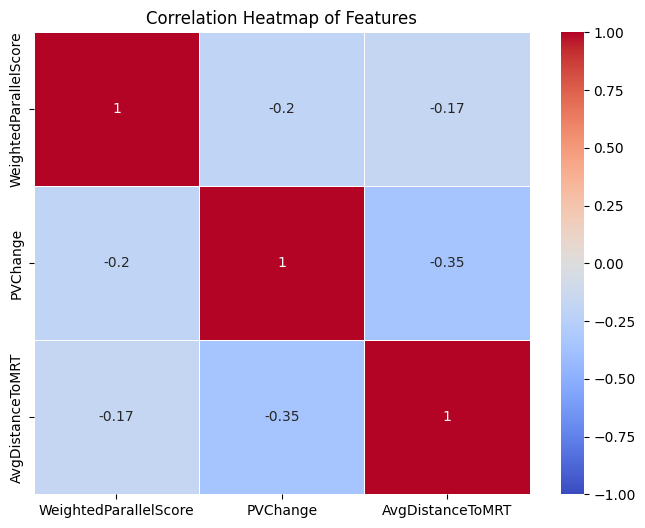

In [354]:
# Select only relevant features for correlation
features = top_20_features[['WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']]

# Calculate the correlation matrix
corr_matrix = features.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()


### Hierarchical Clustering : 50 Bus Services

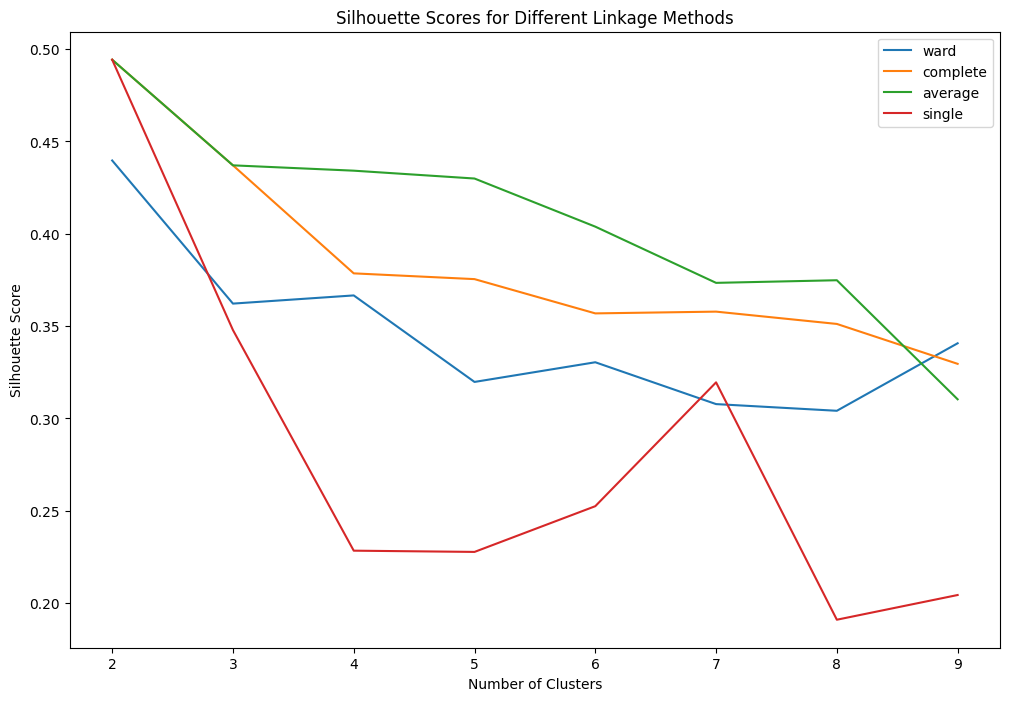

In [355]:
# Test different linkage methods and number of clusters
linkage_methods = ['ward', 'complete', 'average', 'single']
silhouette_scores = {}

for method in linkage_methods:
    linked = linkage(features_scaled, method=method)
    silhouette_scores[method] = []

    # Test silhouette score for different number of clusters
    for k in range(2, 10):  # Test from 2 to 10 clusters
        cluster_labels = fcluster(linked, k, criterion='maxclust')
        score = silhouette_score(features_scaled, cluster_labels)
        silhouette_scores[method].append(score)

# Plot silhouette scores for each method
plt.figure(figsize=(12, 8))
for method in silhouette_scores:
    plt.plot(range(2, 10), silhouette_scores[method], label=method)

plt.title("Silhouette Scores for Different Linkage Methods")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

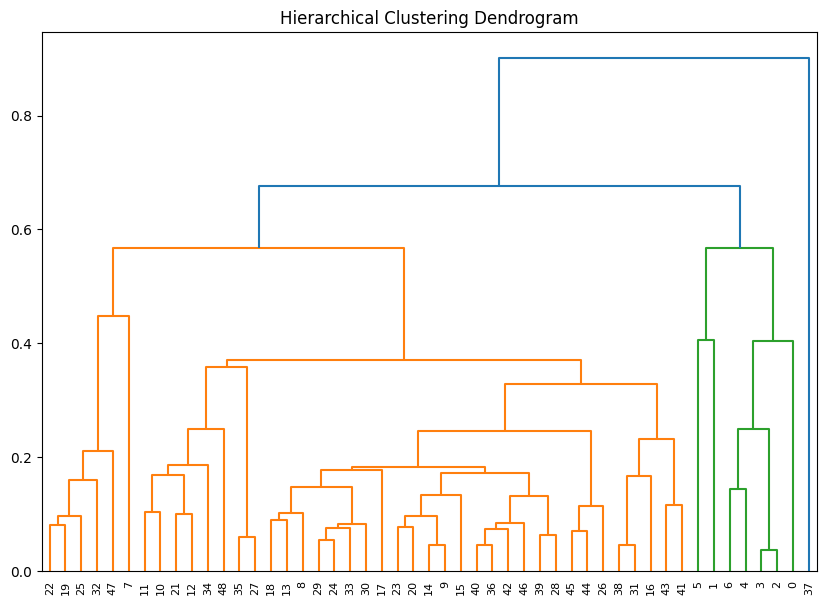

Cluster assignments:
   ServiceNo  WeightedParallelScore  PVChange  AvgDistanceToMRT  Clusters_KNN  \
0         67               1.181314 -0.842202          0.737742             2   
1          2               1.070266 -0.140829          0.848269             2   
2         48               1.032547 -0.506475          0.773233             2   
3        170               1.012027 -0.424945          0.772111             2   
4        107               0.939744 -0.029855          0.745774             2   
5         26               0.939020 -1.689713          0.897184             2   
6        133               0.854870 -0.059349          0.751249             1   
7         36               0.839344  0.900896          0.668416             1   
8         24               0.742000 -0.133153          0.823632             0   
9        147               0.740808 -0.255087          0.790455             0   
10        10               0.736486  0.133963          0.855912             0   
11     

In [356]:
# Perform hierarchical clustering
linked = linkage(features_scaled, method='average')
# Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()

# Cut the dendrogram to form clusters
num_clusters = 3
cluster_labels = fcluster(linked, num_clusters, criterion='maxclust')

# Step 5: Add cluster labels to your original DataFrame
top_50_features['Cluster_HC'] = cluster_labels-1

# Step 6: Analyze the clusters
print("Cluster assignments:")
print(top_50_features)


In [357]:
top_50_features

,ServiceNo,WeightedParallelScore,PVChange,AvgDistanceToMRT,Clusters_KNN,Cluster_HC
0,67,1.181314,-0.842202,0.737742,2,0
1,2,1.070266,-0.140829,0.848269,2,0
2,48,1.032547,-0.506475,0.773233,2,0
3,170,1.012027,-0.424945,0.772111,2,0
4,107,0.939744,-0.029855,0.745774,2,0
5,26,0.939020,-1.689713,0.897184,2,0
6,133,0.854870,-0.059349,0.751249,1,0
7,36,0.839344,0.900896,0.668416,1,1
8,24,0.742000,-0.133153,0.823632,0,1
9,147,0.740808,-0.255087,0.790455,0,1


### Hierarchical Clustering : 20 Bus Services

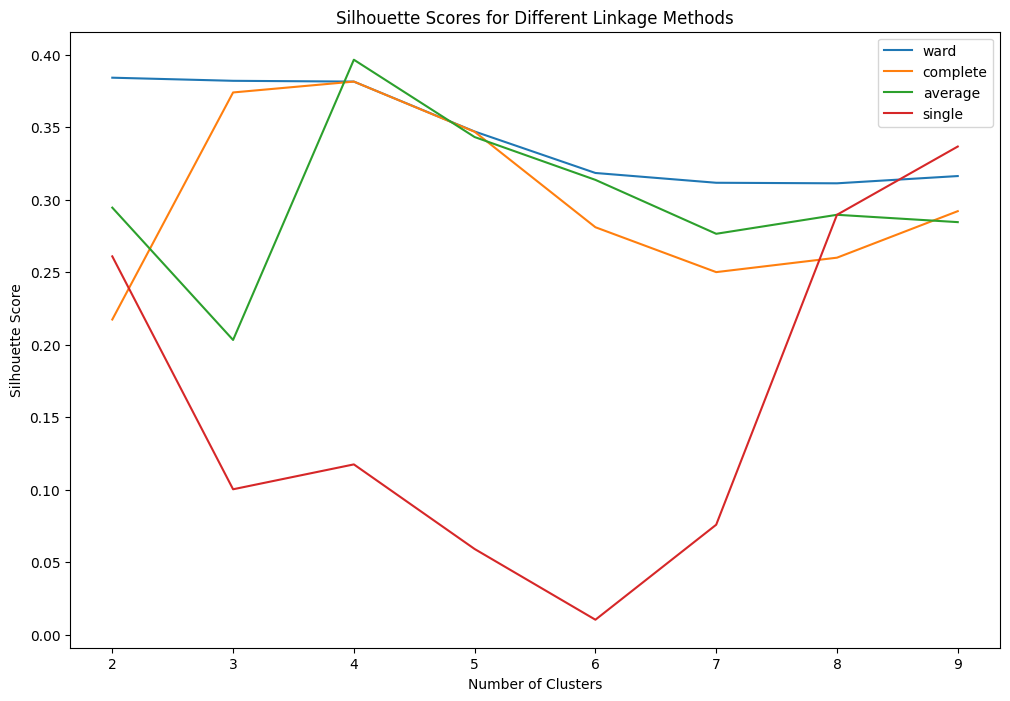

In [358]:
# Test different linkage methods and number of clusters
linkage_methods = ['ward', 'complete', 'average', 'single']
silhouette_scores = {}

for method in linkage_methods:
    linked = linkage(features_scaled_20, method=method)
    silhouette_scores[method] = []

    # Test silhouette score for different number of clusters
    for k in range(2, 10):  # Test from 2 to 10 clusters
        cluster_labels = fcluster(linked, k, criterion='maxclust')
        score = silhouette_score(features_scaled_20, cluster_labels)
        silhouette_scores[method].append(score)

# Plot silhouette scores for each method
plt.figure(figsize=(12, 8))
for method in silhouette_scores:
    plt.plot(range(2, 10), silhouette_scores[method], label=method)

plt.title("Silhouette Scores for Different Linkage Methods")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()


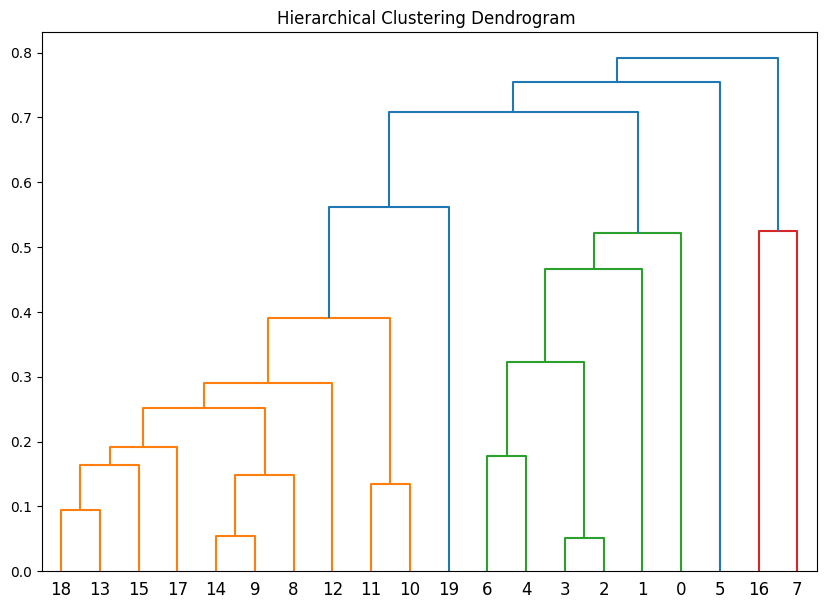

Cluster assignments:
   ServiceNo  WeightedParallelScore  PVChange  AvgDistanceToMRT  Clusters_KNN  \
0         67               1.181314 -1.093576          0.737742             2   
1          2               1.070266 -0.238558          0.848269             2   
2         48               1.032547 -0.734054          0.773233             2   
3        170               1.012027 -0.623571          0.772111             2   
4        107               0.939744 -0.088174          0.745774             2   
5         26               0.939020 -2.242063          0.897184             1   
6        133               0.854870 -0.032710          0.751249             0   
7         36               0.839344  1.268546          0.668416             0   
8         24               0.742000 -0.228155          0.823632             1   
9        147               0.740808 -0.297960          0.790455             1   
10        10               0.736486  0.229253          0.855912             1   
11     

In [359]:
#Perform hierarchical clustering
linked = linkage(features_scaled_20, method='average')

# Step 3: Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram ')
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()

# Step 4: Cut the dendrogram to form clusters
num_clusters = 4
cluster_labels = fcluster(linked, num_clusters, criterion='maxclust')

# Step 5: Add cluster labels to your original DataFrame
top_20_features['Cluster_HC'] = cluster_labels-1

# Step 6: Analyze the clusters
print("Cluster assignments:")
print(top_20_features)

In [360]:
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.spatial.distance import pdist, squareform

# Your data here
data = top_20_features[['WeightedParallelScore', 'PVChange', 'AvgDistanceToMRT']].values

# Parameters for clustering
k1 = 3  # Number of clusters for KMeans
k2 = 4 # Number of clusters for Hierarchical Clustering
final_k = 4 # Desired number of clusters for consensus clustering

# Run KMeans
kmeans = KMeans(n_clusters=k1, random_state=42)
kmeans_labels = kmeans.fit_predict(data)

# Run Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=k2)
hc_labels = hc.fit_predict(data)

# Create a co-association matrix
n_samples = len(data)
co_assoc_matrix = np.zeros((n_samples, n_samples))

# Increment matrix based on clustering results
for i in range(n_samples):
    for j in range(i, n_samples):
        if kmeans_labels[i] == kmeans_labels[j]:
            co_assoc_matrix[i, j] += 1
            co_assoc_matrix[j, i] += 1
        if hc_labels[i] == hc_labels[j]:
            co_assoc_matrix[i, j] += 1
            co_assoc_matrix[j, i] += 1

# Normalize by the number of clustering methods used (in this case, 2)
co_assoc_matrix /= 2

# Apply consensus clustering on the co-association matrix
consensus_clustering = AgglomerativeClustering(n_clusters=final_k, metric='precomputed', linkage='average')
final_labels = consensus_clustering.fit_predict(1 - co_assoc_matrix)

# Display the consensus clustering labels
print("Consensus Clustering Labels:", final_labels)

# Add the consensus labels to the DataFrame for analysis
top_20_features_df['Consensus_Cluster'] = final_labels

# Validation: ARI and NMI between consensus clustering and initial clustering methods
ari_kmeans = adjusted_rand_score(kmeans_labels, final_labels)
ari_hc = adjusted_rand_score(hc_labels, final_labels)
nmi_kmeans = normalized_mutual_info_score(kmeans_labels, final_labels)
nmi_hc = normalized_mutual_info_score(hc_labels, final_labels)

print(f"ARI between Consensus and KMeans: {ari_kmeans}")
print(f"ARI between Consensus and Hierarchical Clustering: {ari_hc}")
print(f"NMI between Consensus and KMeans: {nmi_kmeans}")
print(f"NMI between Consensus and Hierarchical Clustering: {nmi_hc}")


Consensus Clustering Labels: [1 2 1 1 2 3 2 0 2 2 2 0 1 1 2 1 0 3 1 2]
ARI between Consensus and KMeans: 0.6853102306026245
ARI between Consensus and Hierarchical Clustering: 0.873552508984427
NMI between Consensus and KMeans: 0.7674173285465616
NMI between Consensus and Hierarchical Clustering: 0.8963690640598219
